# Score-matching informed KDE

In [1]:
"""
%pip install memory_profiler
%pip install tqdm
%pip install matplotlib
%pip install scikit-learn
%pip install pandas
"""
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import argparse
import pandas as pd
from pandas.plotting import scatter_matrix as pdsm
#import function_cpu as LearnCholesky
from WPO_SGM import toy_data
from WPO_SGM import functions_WPO_SGM as LearnCholesky
import torch.multiprocessing as mp
import logging

from memory_profiler import profile
from tqdm import trange
import time
import gc
# git testing

In [2]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPU is not available")
print(device)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"

#device = torch.device('cpu')
torch.set_float32_matmul_precision('high')

GPU is not available
cpu


### Parsing for scripts

In [3]:
parser = argparse.ArgumentParser(' ')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings','swissroll_6D_xy1', 'cifar10'], type = str,default = '2spirals')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 5)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 64)
parser.add_argument('--niters',type = int, default = 50000)
parser.add_argument('--batch_size', type = int,default = 2)
parser.add_argument('--lr',type = float, default = 2e-3) 
parser.add_argument('--save',type = str,default = 'cifar10_experiments/')
parser.add_argument('--train_kernel_size',type = int, default = 10)
parser.add_argument('--train_samples_size',type = int, default = 50000)
parser.add_argument('--test_samples_size',type = int, default = 5)
args = parser.parse_args('')

In [4]:
train_kernel_size = args.train_kernel_size
train_samples_size = args.train_samples_size
test_samples_size = args.test_samples_size
dataset = args.data 
save_directory = args.save + 'test'+'/'

print('save_directory',save_directory)

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print('Created directory ' + save_directory)

save_directory cifar10_experiments/test/


### Precision matrix model

In [5]:
## Cholesky factor model
def construct_factor_model(dim:int, depth:int, hidden_units:int):
    '''
    Initializes neural network that models the Cholesky factor of the precision matrix # For nD examples (in theory)
    '''
    chain = []
    chain.append(nn.Linear(dim,int(hidden_units),bias =True)) 
    chain.append(nn.GELU())

    for _ in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),int(dim*(dim+1)/2),bias = True)) 

    return nn.Sequential(*chain)   

### Helper functions

In [6]:
#@profile
# Define a compiled function that takes factornet, samples, centers as inputs
compiled_score = torch.compile(LearnCholesky.score_implicit_matching)

def evaluate_model(factornet, kernel_centers, num_test_sample):
    '''
    Evaluate the model by computing the average total loss over 10 batch of testing samples
    '''
    with torch.no_grad():
        total_loss_sum = 0
        device = kernel_centers.device
        for i in range(10):
            p_samples = toy_data.inf_train_gen(dataset,batch_size = num_test_sample)
            testing_samples = torch.as_tensor(p_samples, dtype=torch.float32, device=device)
            total_loss = compiled_score(factornet, testing_samples, kernel_centers)
            total_loss_sum += total_loss.item()
             # Free up memory
            del p_samples, testing_samples, total_loss
            gc.collect() #only if using CPU
            torch.cuda.empty_cache()  # Only if using GPU
        average_total_loss = total_loss_sum / 10
    return average_total_loss

def save_training_slice_cov(factornet, means, epoch, lr, batch_size, loss_value, save):
    '''
    Save the training slice of the NN
    '''
    if save is not None:
        torch.save(factornet.state_dict(), save + 'epoch' + str(epoch)  + 'lr' + str(lr) + 'batch_size' + str(batch_size) + 'model_weights.pth')
        #save the centers
        torch.save(means, save + 'epoch' + str(epoch) + 'centers.pth')

def save_training_slice_log(factornet, means, epoch, lr, batch_size, loss_value, save):
    '''
    Save the training log for the slice
    '''
    if save is not None:
        log_filename = os.path.join(save, f'epoch{epoch}_training.log')
        # log training data
        # Construct log filename


# Configure logging to write to this dynamic file (and also console if you want)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler()
    ]
)

# Now logging calls will write to cifar10_experiments/epoch3_training.log
logging.info("Training started for epoch %d", epoch)

NameError: name 'log_filename' is not defined

### Initialize score network

In [ ]:
"""
# check the dataset
dataset = args.data
dataset = 'swissroll'
# dataset = 'swissroll_6D_xy1'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)
"""

## Initialize Data using CIFAR-10


In [8]:
# check the dataset
torch.cuda.empty_cache()
dataset = args.data
dataset = 'cifar10'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)
data_dim = means.shape[1]
del means
torch.cuda.empty_cache()
# dataset = 'swissroll_6D_xy1'
""""" # not used anymore since our data is pictures
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)
"""


tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_33036\1167857191.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)


'"" # not used anymore since our data is pictures\nmeans  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)\ndata_dim = means.shape[1]\nprint(\'data_dim\',data_dim)\n\nblah = pd.DataFrame(means)\npdsm(blah)\n'

In [9]:
depth = args.depth
hidden_units = args.hiddenunits
factornet = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)
factornet = torch.compile(factornet, mode="reduce-overhead")

lr = args.lr
optimizer = optim.Adam(factornet.parameters(), lr=args.lr)

p_samples = toy_data.inf_train_gen(dataset,batch_size = train_samples_size)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)

epochs = args.niters
batch_size = args.batch_size
torch.save(centers, save_directory + str(epochs) + 'epochs' + str(train_kernel_size) + 'centers.pt')
del p_samples
"""
# Training the score network
loss = evaluate_model(factornet, centers, test_samples_size)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'Before train, Average total_loss: {formatted_loss}')
"""

tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_33036\563120124.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_33036\563120124.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)


"\n# Training the score network\nloss = evaluate_model(factornet, centers, test_samples_size)\nformatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision\nprint(f'Before train, Average total_loss: {formatted_loss}')\n"

In [ ]:
#@profile
gc.collect()
torch.cuda.empty_cache()

scaler = torch.amp.GradScaler('cuda') #mixed precision gradient scaler

def opt_check(factornet, samples, centers):
    optimizer.zero_grad()
    loss = LearnCholesky.score_implicit_matching(factornet, samples, centers)  # autocast inside
    scaler.scale(loss).backward() #loss.backward()
    scaler.step(optimizer) #optimizer.step()
    scaler.update()
    return loss

compiled_opt_check = torch.compile(opt_check)

for step in trange(epochs, desc="Training"):
    randind = torch.randint(0, train_samples_size, [batch_size,])
    samples = training_samples[randind, :]
    
    loss_value = compiled_opt_check(factornet, samples, centers).item()
    print(f"Peak memory usage: {torch.cuda.max_memory_allocated() / 2**30:.2f} GiB")
    if step % 4000 == 0:
        print(f"Step {step} started")
        print(f'Step: {step}, Loss value: {loss_value:.3e}')
    
    if step % 20000 == 0:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)

    if step < epochs - 1:
        del samples
        gc.collect()
        torch.cuda.empty_cache()


In [ ]:
loss0 = evaluate_model(factornet, centers, test_samples_size)    
save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
formatted_loss = f'{loss0:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

In [ ]:
formatted_loss = f'{loss0:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

In [ ]:

import time

for step in range(epochs):
    start = time.time()
    # samples_toydata
    randind = torch.randint(0,train_samples_size,[batch_size,])
    samples = training_samples[randind,:]
    loss_value = opt_check(factornet, samples, centers)
    """
    loss = LearnCholesky.score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    """
   
    
    if not step % 4000:
        #loss_value = loss.item()
        print(f'Step: {step}, Loss value: {loss_value:.3e}')

    if not step % 20000:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
    if step < epochs - 1:
         # Free up memory
        del samples # del loss
        gc.collect()
        torch.cuda.empty_cache()
    print("Elapsed time:", time.time() - start)
    
loss = evaluate_model(factornet, centers, test_samples_size)    
save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

In [34]:
gc.collect()
torch.cuda.empty_cache()
def plot_images(means, precisions, epoch = 0, plot_number = 10, save_path=None):
    # plots plot_number samples from the trained model for image data
    num_components = means.shape[0]
    # sample from the multivariate normal distribution
    comp_num = torch.randint(0, num_components, (1,plot_number)) #shape: [1, plot_number]
    comp_num = comp_num.squeeze(0)  # shape: [plot_number]
    multivariate_normal = torch.distributions.MultivariateNormal(means[comp_num], precision_matrix=precisions[comp_num])
    samples = multivariate_normal.rsample()
    # transform images back to original data 
    samples = samples.view(-1, 3, 32, 32)
    samples = samples * 0.5 + 0.5
    fig, axs = plt.subplots(1, plot_number, figsize=(15, 2))
    for i in range(plot_number):
        img = samples[i].permute(1, 2, 0).cpu().numpy()  # change from [C, H, W] to [H, W, C]
        axs[i].imshow(img)
        axs[i].axis('off')
    if save_path is not None:
        save_path = save_path + 'epoch'+ str(epoch) + '.png'
        plt.savefig(save_path)
    

    return None
def load_model(model, centers, load_model_path, load_centers_path):   
    """
    Loads model weights from the specified path.
    """
    if load_model_path is not None and os.path.exists(load_model_path):
        state_dict = torch.load(load_model_path, map_location=device)
        
        # Strip "module." prefix if present
        if any(k.startswith("module.") for k in state_dict.keys()):
            from collections import OrderedDict
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                new_state_dict[k.replace("module.", "")] = v
            state_dict = new_state_dict
        
        # Strip "_orig_mod." prefix if present
        if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
            from collections import OrderedDict
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                new_state_dict[k.replace("_orig_mod.", "")] = v
            state_dict = new_state_dict
        
        model.load_state_dict(state_dict)
        logging.info(f"Loaded model weights from {load_model_path}")
    
    if load_centers_path is not None and os.path.exists(load_centers_path):
        centers = torch.load(load_centers_path, map_location=device)
        logging.info(f"Loaded centers from {load_centers_path}")
    else:
        print(f"No model loaded. Path does not exist: {load_model_path}")
    
    return model, centers


# sample from trained model
# and plot density
#file /wpo_distill/cifar10_experiments/test/epoch499model_weights.pth
#factornet.load_state_dict(torch.load('wpo_distill/cifar10_experiments/test/epoch499model_weights.pth'))
print(os.path.exists("/workspace/cifar10_experiments/test/epoch1501model_weights.pth"))
print("Current working dir:", os.getcwd())
model = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)
centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)
model, centers = load_model(model, centers, "cifar10_experiments/test/sample_size5000/test_size5/batch_size2/centers50/lr0.0002/loaded/sample_size5000/test_size5/batch_size2/centers50/lr0.0002/epoch19999_factornet.pth","cifar10_experiments/test/sample_size5000/test_size5/batch_size2/centers50/lr0.0002/loaded/sample_size5000/test_size5/batch_size2/centers50/lr0.0002/centers.pt")
#centers = torch.load("cifar10_experiments/test/sample_size500_test_size2_batch_size2_centers10_lr0.002centers.pt", map_location=device)
model = model.to('cpu')
centers = centers.to('cpu')
#model.load_state_dict(torch.load("/workspace/cifar10_experiments/test/epoch1501model_weights.pth"))
epochs = 23000

"""
with torch.no_grad():
        
    precisions = LearnCholesky.vectors_to_precision(model(centers),data_dim)

    plot_images(centers, precisions, epoch = epochs, plot_number=10, save_path=save_directory + 'samples')
"""
""" I think this will not work for general (centers needs to be same as before to plot properly)
randind = torch.randint(0,1000,[1000,])
centers = means[randind,:].to(device)
precisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)

LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 0, dim2 = 1,save_path=save_directory + 'samples.png')
LearnCholesky.plot_density_2d_marg(centers,factornet,dim1 = 0, dim2 = 1, save_path=save_directory + 'density.png')
"""
plt.show()

False
Current working dir: c:\Users\pongd\diffusion model research\wpo_distill
tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_33036\4043436518.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

Saving images to: cifar10_experiments/test/epoch0testing


Sample stats: -25.275033950805664 31.093318939208984 -0.06293138861656189


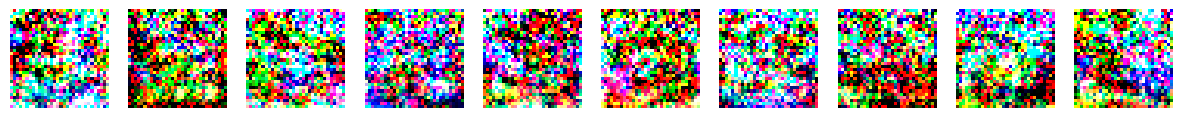

In [ ]:
def sample_from_model(factornet, means, sample_number):
    num_components, dim = means.shape
    comp_num = torch.randint(0, num_components, (sample_number,), device=means.device)
    samples = torch.empty(sample_number, dim, device=means.device)

    unique_indices = comp_num.unique()

    for i in unique_indices:
        idx = (comp_num == i).nonzero(as_tuple=True)[0]
        n_i = idx.shape[0]
        centers_i = means[i].unsqueeze(0).expand(n_i, -1)  # [n_i, dim]

        # Get model output vectors (flattened Cholesky)
        vectors = factornet(centers_i)  # [n_i, d*(d+1)//2]

        # Use your existing function to get precision matrix with stabilization
        precision = LearnCholesky.vectors_to_precision(vectors, dim)  # [n_i, dim, dim]

        # Create multivariate normal with precision matrix
        mvn = MultivariateNormal(loc=centers_i, precision_matrix=precision)

        # Sample from this distribution
        samples_i = mvn.rsample()  # [n_i, dim]

        samples[idx] = samples_i

    return samples


import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

def plot_images_with_model(factornet, means, plot_number=10, save_path=None):
    # sample from the model
    num_components = means.shape[0]
    dim = means.shape[-1]

    # sample [plot_number, dim] from model
    samples = sample_from_model(factornet, means, plot_number)

    print("Sample stats:", samples.min().item(), samples.max().item(), samples.mean().item())

    # reshape to [N, 3, 32, 32] if needed
    samples = samples.view(-1, 3, 32, 32)

    # unnormalize from [-1, 1] back to [0, 1]
    samples_unnorm = samples * 0.5 + 0.5

    # convert to uint8 for PIL
    samples_img = (samples_unnorm * 255).clamp(0, 255).to(torch.uint8)

    # display one sample
    """
    to_pil = T.ToPILImage()
    img = to_pil(samples_img[0].cpu())
    img.show()
    """

    # plot multiple samples
    fig, axs = plt.subplots(1, plot_number, figsize=(15, 2))
    for i in range(plot_number):
        img_np = samples_unnorm[i].permute(1, 2, 0).cpu().numpy()  # [C,H,W] -> [H,W,C]
        axs[i].imshow(img_np)
        axs[i].axis('off')

    if save_path is not None:
        save_path = save_path + '_sampled_images.png'
        plt.savefig(save_path)

    return None


with torch.no_grad():
    filename_final = save_directory + 'epoch' + str(epochs) + 'testing'
    print("Saving images to:", filename_final)
    # sample from the trained model
    plot_images_with_model(model, centers, plot_number=10, save_path=filename_final)
plt.show()

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# Load model and checkpoint
model = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype=torch.float32)
state_dict = torch.load("cifar10_experiments/test/sample_size500_test_size2_batch_size2_centers10_lr0.002_epoch0009_factornet.pth", map_location=device)

new_state_dict = {}
for k, v in state_dict.items():
    new_key = k
    if k.startswith("module."):
        new_key = k[len("module."):]  # Remove 'module.' prefix
    new_state_dict[new_key] = v
centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)
load_result = model.load_state_dict(new_state_dict)

centers = torch.load("cifar10_experiments/test/sample_size500_test_size2_batch_size2_centers10_lr0.002centers.pt", map_location='cpu')
centers = centers.to('cpu')

with torch.no_grad():
    precisions = LearnCholesky.vectors_to_precision(model(centers), data_dim)
precisions = precisions.to('cpu')

plot_images(centers, precisions, epoch=epochs, plot_number=10, save_path=save_directory + 'samples')


In [ ]:
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 2, dim2 = 3, save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 2, dim2 = 3, save_path=save_directory + 'density.png')
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 4, dim2 = 5,  save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 4, dim2 = 5,save_path=save_directory + 'density.png')